# Predicting Bike Rentals Using Decision Tree Models

In this project, we will look at data from University of Urvine regarding the number of bike rentals in Washington DC. Our goal will be to predict the number of bikes rented during different parts of the day. This kind of prediction is helpful for cities that are trying to determine where to place bike rental racks and how often to refill those bikes based on demand. We will use three different models to attempt to predict the number of bike rentals throughout the day:
- Linear Regression
- Decision Trees
- Random Forest

We'll evaluate the results of each model at the end and determine which would be most helpful for planners of DC's bike rental program.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Data Overview

First, we'll explore the data to get a sense of how to construct our modela and determine what data to use.

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [6]:
print(bike_rentals.shape)
bike_rentals.head()

(17379, 17)


instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

We will use the CNT column to see how many bike rentals there were in a given day. CNT is combination of the number of casual and registered bike rental in a given hour. Casual means that a renter is not a registered member of the bike rental program and Registered means the renter is a member of the bike rental program. This distinction isn't important to our current goal but could be useful in other analysis. 

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <BarContainer object of 10 artists>)

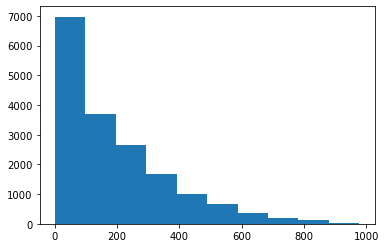

In [18]:
%matplotlib inline
 
plt.hist(bike_rentals["cnt"])

In [10]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Cleaning Data

Before we start building our models, let's clean up the time label column. Right now, it lists every hour in the day and this will make it more difficult for our models to generate accurate decisions. Instead, we will bucket each rental into one of 4 times throughout the day: morning, afternoon, evening, and night. We will still use numeric values for the purposes of building the models. 

In [10]:
def assign_label(val):
    if val >= 6 and val < 12:
        return 1
    if val >=12 and val < 18:
        return 2
    if val >= 18 and val < 24:
        return 3
    if val >= 0 and val < 6:
        return 4

In [11]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [12]:
bike_rentals['time_label'].value_counts()


2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Splitting Data

In order to train and test our model, we will split the data into two separate dataframes. We will put 80% of the data in the training set and the remaining 20% in the testing set. 

In [13]:
train = bike_rentals.sample(frac=.8)

In [14]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression

For our first model, we'll try using linear regression. Linear Regression can be a good choice when the predictor values are correlated and independent with respect to the target data. This is the case with our dataset. However, linear regression does have a tendency to underfit data, which can led to less accurate predictions.

Let's see how it goes.

In [15]:
#preparing columns to use for predictions
columns = list(bike_rentals.columns)
columns.remove("cnt")
columns.remove("casual")
columns.remove("dteday")
columns.remove("registered")


In [19]:
#Running linear regression and generating predictions on test data
lr = LinearRegression()
lr = lr.fit(train[columns], train['cnt'])
pred = lr.predict(test[columns])

To test the accuracy of the data, we will use Mean Squared Error MSE. MSE is helpful metric to use when for continous numerical data-which is what we dealing with in this case. In general, high MSE rates means a model is less accurate, whereas low MSE rates means a model in more accurate

In [20]:
#Calculating error for test data prediction
mse = mean_squared_error(test['cnt'], pred)
print(mse)

18110.631807465583


The error rate for linear model is pretty high. This might be because there are some outlier days in the data with extremely high numbers of rentals which is skewing the regression.

## Decision Tree

Next, we'll try predicting the number of bikes rented at different times of day using a Decision Tree model. In general, Decision Trees tend to provide more accurate predictions than Linear Regression because they are more complex. However, Decision Trees are also prone to overfitting data compared to Linear Regssion models. Let's see how the Decision Tree model does with our bike rental prediction.

In [24]:
#building decision tree algorithm
dtr = DecisionTreeRegressor()
dtr = dtr.fit(train[columns], train["cnt"])

In [25]:
#Getting predictions on test data
predictions = dtr.predict(test[columns])

In [26]:
#Calculating accuracy of classifer using MSE
mse_dtr = mean_squared_error(test["cnt"], predictions)
print(mse_dtr)

3589.323072497123


This is a much more accurate model compared to Linear Regession! Since we know Decision Trees have a tendency to overfit data, let's try changing some parameters of the model to see if we can further reduce the error rate. We will change the min_sample_leaf from 1 to 7. Changing the minimum sample leaf parameter helps prevent the Decision Tree from getting too "deep" and potentially creating nodes that are essentially one offs.

In [27]:
#Increasing minimum samples for a leaf to hopefully 
#increase model's accuracy 
dtr2 = DecisionTreeRegressor(min_samples_leaf=7)
dtr2 = dtr2.fit(train[columns],train["cnt"])

predictions2 = dtr2.predict(test[columns])
mse_tree2 = mean_squared_error(test["cnt"], predictions2)
print(mse_tree2)

2728.2043742770206


The increase in min_sample_leafs definitely helped make the decision tree more accurate.

## Random Forest Model

Next, we will use a Random Forest model to see if we can improve the the accuracy over the decision tree  and linear regression. Random forests are even more complex than decision trees. While they still are prone to overfitting, they are less likely to overfit than a decision tree model because random forest models help minimize variance.

In [55]:
#Building random forest model, making predictions
#on test data, and calculating error of predictions
rf = RandomForestRegressor()
rf = rf.fit(train[columns], train['cnt'])
rf_pred = rf.predict(test[columns])
mse_rf = mean_squared_error(test['cnt'], rf_pred)
print(mse_rf)

1851.3854344073648


The random forest regressor is much more accurate than the linear regression and decision tree model. Let's see if we can make any changes to the parameters of the model to improve accuracy. Like we did with the decision tree, we will increase the min_sample_leaf from 1 to 2.

In [32]:
#Building random forest model, making predictions
#on test data, and calculating error of predictions
rf2 = RandomForestRegressor(min_samples_leaf=2)
rf2 = rf2.fit(train[columns], train['cnt'])
rf_pred2 = rf2.predict(test[columns])
mse_rf2 = mean_squared_error(test['cnt'], rf_pred2)
print(mse_rf2)

1854.3694988185077


It seems like changing the min_sample_leaf in this case does not improve the model's accuracy. Future analysis might continue to play with parameters of the random forest model, including the depth for each leaf. For now, I think a random forest model with the default parameters would make the best model for bike rental planenrs to determine how many bikes are rented at different times of the day